In [1]:
import numpy as np
import pandas as pd
import gym
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import clear_output
import time

In [2]:
REPS = 20
EPISODES = 2000
TEST_EPISODE=20
EPSILON = 0.4
LEARNING_RATE = 0.1
MIN_EPSILON=0.01
MIN_LEARNING_RATE = 0.01
DISCOUNT = 0.9
STUDENT_NUM =64
WINDOW_SIZE=50
action_space={0:'down',1:'up',2:'right',3:'left',4:'pick-up',5:'drop-off'}
place={0:'R',1:'G',2:'Y',3:'B',4:'In Taxi'}

In [3]:
env = gym.make('Taxi-v3')
n_states=env.observation_space.n 

In [4]:
def epsilon_greedy(Q,current_state,epsilon=EPSILON):
    if np.random.uniform(0,1)<epsilon:
        return np.random.choice(list(action_space.keys()))
    else:
        return np.argmax(Q[current_state,:])

In [5]:
def greed_policy(policy,Q,current_state=None):
    if current_state == None:
        for s in range(n_states):
            action=np.random.choice(list(action_space.keys()))
            policy[s][:]=0
            policy[s][action]=1
    else:
        action=np.argmax(Q[current_state])
        policy[current_state][:]=0
        policy[current_state][action]=1
    return policy

In [6]:
def print_detail(current_state,current_action,reward,r,e,i):
    print("="*50)
    taxi_row, taxi_col, pass_idx, dest_idx = env.decode(current_state)
    text="Repeat:%d Episode:%d Step:%d\n   Action: %s\n   Reward: %s\n   Passenger: %s\n   Destination: %s"%(r,e,i,action_space[current_action],reward,place[pass_idx],place[dest_idx])
    print(text)

In [7]:
def test_agent(Q):
    t_Terminal=[]
    for e in range(TEST_EPISODE):
        start=time.time()
        env.seed(STUDENT_NUM)
        current_state=env.reset()
        print("="*50)
        print("Initial State")
        env.render()
        Terminal=False
        i=0
        while(Terminal == False):
            current_action=np.argmax(Q[current_state])
            next_state,observed_reward,Terminal,_=env.step(current_action)
            current_state=next_state
            print_detail(current_state,current_action,observed_reward,0,e,i)
            env.render()
            if Terminal:
                t_Terminal.append(i)
                print("Reach Terminal!")
                print("="*50)
            i+=1
    print("~"*50)
    print("Total Execution Time: %.5f Seconds"%(time.time()-start))
    print("Agent %d of %d times reaches Terminal."%(len(t_Terminal),TEST_EPISODE))
    print("Maximum number of step to reach Terminal: %d"%max(t_Terminal))

## Q1 

In [8]:
def Q_learning(env=env,lr=LEARNING_RATE,epsilon=EPSILON,lr_decay=False,print_info=False):
    start=time.time()
    t_terminal=[]
    episode_reward=np.zeros(shape=(EPISODES,REPS))
    Q=np.zeros(shape=(n_states,len(action_space.keys())))
    for r in range(REPS):
        epsilon_trace=[]
        lr_trace=[]
        epsilon=EPSILON
        for e in range(EPISODES):
            print("Repeat: %d Episode:%d"%(r,e))
            clear_output(wait=True)
            env.seed(seed = STUDENT_NUM)
            current_state=env.reset()
            Terminal=False
            total_reward=0
            i=0
            while(Terminal==False):
                i+=1
                current_action=epsilon_greedy(Q,current_state,epsilon)
                next_state,observed_reward,Terminal,_=env.step(current_action)
                Q[current_state][current_action]+=lr*(observed_reward+DISCOUNT*np.max(Q[next_state][:])-Q[current_state][current_action])
                current_state=next_state
                total_reward+=observed_reward
                # Notice: if print_info be false, function will execute faster.
                if print_info:
                    print_detail(current_state,current_action,r,e,i)
                    env.render()
                    clear_output(wait=True)
            t_terminal.append(e)
            episode_reward[e][r]=total_reward
            epsilon=(EPSILON-MIN_EPSILON)*max(0,(EPISODES-e)/EPISODES)+MIN_EPSILON
            epsilon_trace.append(epsilon)
            if lr_decay:
                lr=(LEARNING_RATE-MIN_LEARNING_RATE)*max(0,(EPISODES-e)/EPISODES)+MIN_LEARNING_RATE
                lr_trace.append(lr)
    print("Total Execution Time: %.2f Seconds"%(time.time()-start))
    return Q,episode_reward,epsilon_trace,lr_trace

### Training

In [9]:
Q_Qlearning,Res_Q,_,_=Q_learning(env,epsilon=0.4,print_info=False)

Total Execution Time: 59.09 Seconds


In [10]:
Q_Qlearning_decay,Res_Q_Decay,eps_decay,lr_decay=Q_learning(env,epsilon=0.4,lr_decay=True,print_info=False)

Total Execution Time: 59.52 Seconds


In [11]:
Result_Q=pd.DataFrame(np.mean(Res_Q,axis=1))
Result_Q_Decay=pd.DataFrame(np.mean(Res_Q_Decay,axis=1))
Result_Q=Result_Q.rolling(WINDOW_SIZE).mean()
Result_Q_Decay=Result_Q_Decay.rolling(WINDOW_SIZE).mean()

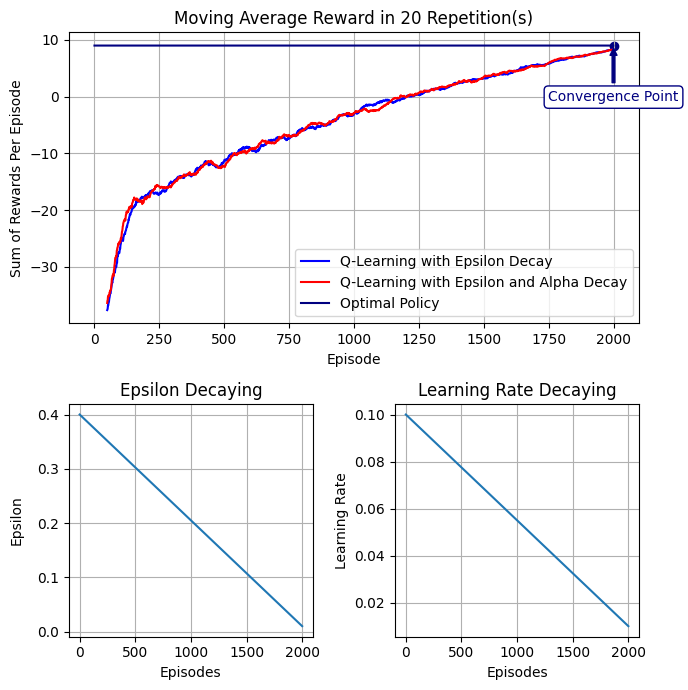

In [12]:
fig = plt.figure(tight_layout=True,figsize=(7,7))
gs = gridspec.GridSpec(2, 2,height_ratios=[5,4])

ax = fig.add_subplot(gs[0, :])
ax.plot(Result_Q,'b',label="Q-Learning with Epsilon Decay")
ax.plot(Result_Q_Decay,'r',label="Q-Learning with Epsilon and Alpha Decay")
ax.plot([9]*2000,'navy',label="Optimal Policy")
if Res_Q[EPISODES-1][REPS-1]==Res_Q_Decay[EPISODES-1][REPS-1]:
    if Res_Q[EPISODES-1][REPS-1]==9.0:
        ax.scatter(2000,9,color='navy')
        ax.annotate("Convergence Point",color='navy', xy =(2000, 9),  xycoords='data',
                    bbox=dict(boxstyle="round",fc="white", ec="navy"),
                    xytext=(0, -40), textcoords='offset points', ha='center',
                    arrowprops=dict(arrowstyle="simple",color="navy"))
  

ax.set_ylabel("Sum of Rewards Per Episode")
ax.set_xlabel("Episode")
plt.title("Moving Average Reward in %d Repetition(s)"%REPS)
plt.legend()
plt.grid()

ax = fig.add_subplot(gs[1, 0])
ax.plot(eps_decay)
ax.set_ylabel('Epsilon')
ax.set_xlabel('Episodes')
plt.title("Epsilon Decaying")
plt.grid()

ax = fig.add_subplot(gs[1, 1])
ax.plot(lr_decay)
ax.set_ylabel('Learning Rate')
ax.set_xlabel('Episodes')
fig.align_labels()
plt.title("Learning Rate Decaying")
plt.grid()
plt.show()

### Regret Analysis

In [13]:
Regret_Q_Decay=float(9*EPISODES-np.sum(Result_Q_Decay))
Regret_Q=float(9*EPISODES-np.sum(Result_Q))
if Regret_Q<Regret_Q_Decay:
    print("Q-learning with %.1f learning rate is better than decaying learning rate."%LEARNING_RATE)
else:
    print("Q-learning with decaying learning rate is better than %.1f learning rate."%LEARNING_RATE)
print("The Difference is: %.3f"%abs(Regret_Q_Decay-Regret_Q))

Q-learning with decaying learning rate is better than 0.1 learning rate.
The Difference is: 155.542


### Testing Q1 Results

In [14]:
test_agent(Q_Qlearning_decay)

Initial State
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Repeat:0 Episode:0 Step:0
   Action: up
   Reward: -1
   Passenger: R
   Destination: G
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
Repeat:0 Episode:0 Step:1
   Action: left
   Reward: -1
   Passenger: R
   Destination: G
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
Repeat:0 Episode:0 Step:2
   Action: pick-up
   Reward: -1
   Passenger: In Taxi
   Destination: G
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
Repeat:0 Episode:0 Step:3
   Action: down
   Reward: -1
   Passenger: In Taxi
   Destination: G
+---------+
|R: | : :G|
|_: | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
Repeat:0 Episode:0 Step:4
   Action: down
   Reward: -1
   Passenger: In Taxi
   Destination: G
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | 

## Q2

### Unreachable States With Considering Seed
If we consider the `env.seed(STUDENT_NUM)`, the states that are unreachable will be those in which the Q-value is equal to zero.

In [15]:
Q=pd.DataFrame(Q_Qlearning)
unreach=Q[(Q.T == 0).any()].index.tolist()
print(unreach,"Length:",len(unreach))

[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 14, 15, 16, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 34, 35, 36, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 54, 55, 56, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 74, 75, 76, 78, 79, 80, 82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 94, 95, 96, 98, 99, 100, 102, 103, 104, 105, 106, 107, 108, 110, 111, 112, 114, 115, 116, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 130, 131, 132, 134, 135, 136, 138, 139, 140, 142, 143, 144, 145, 146, 147, 148, 150, 151, 152, 154, 155, 156, 158, 159, 160, 162, 163, 164, 165, 166, 167, 168, 170, 171, 172, 174, 175, 176, 178, 179, 180, 182, 183, 184, 185, 186, 187, 188, 190, 191, 192, 194, 195, 196, 198, 199, 200, 202, 203, 204, 205, 206, 207, 208, 210, 211, 212, 214, 215, 216, 218, 219, 220, 222, 223, 224, 225, 226, 227, 228, 230, 231, 232, 234, 235, 236, 238, 239, 240, 242, 243, 244, 245, 246, 247, 248, 250, 251, 252, 254, 255, 256, 258, 259, 260, 262, 263, 264, 265, 266, 267, 268, 270, 27

### Unreachable States Without Considering Seed

In general case (not considering the `env.seed(STUDENT_NUM)`), there are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations.
Note that there are 400 states that can actually be reached during an episode. The missing states correspond to situations in which the passenger is at the same location as their destination, as this typically signals the end of an episode. Four additional states can be observed right after a successful episodes, when both the passenger and the taxi are at the destination. This gives a total of 404 reachable discrete states.
(Reference: https://www.gymlibrary.dev/environments/toy_text/taxi/)

In [16]:
unreach=[]
for i in range(n_states):
    taxi_row, taxi_col, pass_idx, dest_idx = env.decode(i)
    
    if dest_idx==0: #R
        dest_loc=(0,0)
    elif dest_idx==1:#G
        dest_loc=(0,4)
    elif dest_idx==2:#Y
        dest_loc=(4,0)
    elif dest_idx==3:#B
        dest_loc=(4,3)
        
    if pass_idx == dest_idx:
        if pass_idx!=4 and (taxi_row, taxi_col)!=dest_loc:
            unreach.append(i)
print(unreach,"Length:",len(unreach))

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 480, 485, 490, 495] Length: 96


## Q3

In [17]:
def Sarsa(env=env,lr=LEARNING_RATE,epsilon=EPSILON,lr_decay=False,print_info=False):
    start=time.time()
    t_terminal=[]
    episode_reward=np.zeros(shape=(EPISODES,REPS))
    Q=np.zeros(shape=(n_states,len(action_space.keys())))
    for r in range(REPS):
        epsilon_trace=[]
        lr_trace=[]
        epsilon=EPSILON
        for e in range(EPISODES):
            print("Repeat: %d Episode:%d"%(r,e))
            clear_output(wait=True)
            env.seed(seed = STUDENT_NUM)
            current_state=env.reset()
            Terminal=False
            total_reward=0
            i=0
            current_action=epsilon_greedy(Q,current_state,epsilon)
            while(Terminal==False):
                i+=1
                next_state,observed_reward,Terminal,_=env.step(current_action)
                next_action=epsilon_greedy(Q,next_state,epsilon)
                Q[current_state][current_action]=(1 - lr) * Q[current_state][current_action] + lr * (
                    observed_reward + DISCOUNT * Q[next_state][next_action])
                current_state=next_state
                current_action=next_action
                total_reward+=observed_reward
                # Notice: if print_info be false, function will execute faster.
                if print_info:
                    print_detail(current_state,current_action,r,e,i)
                    env.render()
                    clear_output(wait=True)
            t_terminal.append(e)
            episode_reward[e][r]=total_reward
            epsilon=(EPSILON-MIN_EPSILON)*max(0,(EPISODES-e)/EPISODES)+MIN_EPSILON
            epsilon_trace.append(epsilon)
            if lr_decay:
                lr=(LEARNING_RATE-MIN_LEARNING_RATE)*max(0,(EPISODES-e)/EPISODES)+MIN_LEARNING_RATE
                lr_trace.append(lr)
    print("Total Execution Time: %.2f Seconds"%(time.time()-start))
    return Q,episode_reward,epsilon_trace,lr_trace

In [18]:
def Expected_Sarsa(env=env,lr=LEARNING_RATE,epsilon=EPSILON,epsilon_dacay=False,print_info=False):
    start=time.time()
    episode_reward=np.zeros(shape=(EPISODES,REPS))
    t_terminal=[]
    Q=np.zeros(shape=(n_states,len(action_space.keys())))
    policy=np.zeros(shape=(n_states,len(action_space.keys())))
    policy=greed_policy(policy,Q)
    for r in range(REPS):
        epsilon=EPSILON
        for e in range(EPISODES):
            print("Repeat: %d Episode:%d"%(r,e))
            clear_output(wait=True)
            States=[]
            Actions=[]
            Rewards=[0]
            G_terminal=[]
            env.seed(seed = STUDENT_NUM)
            current_state=env.reset()
            total_reward=0
            Terminal=False
            step=0
            while(Terminal==False):
                step+=1
                current_action=epsilon_greedy(Q,current_state,epsilon)
                next_state,observed_reward,Terminal,_=env.step(current_action)
                total_reward+=observed_reward
                next_action=epsilon_greedy(Q,next_state,epsilon)
                G = observed_reward + DISCOUNT * np.dot(policy[next_state],Q[next_state])
                G_terminal.append(G)
                Q[current_state][current_action]+=lr*(G-Q[current_state][current_action])
                policy=greed_policy(policy,Q,current_state)
                if print_info:
                    print_detail(current_state,current_action,r,e,step)
                    env.render()
                    clear_output(wait=True)
                if Terminal:
                    t_terminal.append(e)
                current_state=next_state
            if epsilon_dacay:
                epsilon=(EPSILON-MIN_EPSILON)*max(0,(EPISODES-e)/EPISODES)+MIN_EPSILON
            episode_reward[e][r]=total_reward
    print("Total Execution Time: %.2f Seconds"%(time.time()-start))
    return Q,episode_reward

In [19]:
def n_step_TB(n,env=env,lr=LEARNING_RATE,epsilon=EPSILON,epsilon_dacay=False,print_info=False):
    start=time.time()
    episode_reward=np.zeros(shape=(EPISODES,REPS))
    t_terminal=[]
    Q=np.random.rand(env.observation_space.n, env.action_space.n)
    policy=np.zeros(shape=(n_states,len(action_space.keys())))
    policy=greed_policy(policy,Q)
    for r in range(REPS):
        epsilon=EPSILON
        for e in range(EPISODES):
            print("Repeat: %d Episode:%d"%(r,e))
            clear_output(wait=True)
            States=[]
            Actions=[]
            Rewards=[]
            env.seed(seed = STUDENT_NUM)
            current_state=env.reset()
            Terminal=False
            States.append((current_state,Terminal))
            current_action=epsilon_greedy(Q,States[0][0],epsilon)
            Actions.append((current_state,current_action))
            total_reward=0
            t=0
            T=np.inf
            tau=0
            while(tau!=T-1):
                if t<T:
                    next_state,observed_reward,Terminal,_=env.step(Actions[t][1])
                    States.append((next_state,Terminal))
                    Rewards.append(observed_reward)
                    total_reward+=observed_reward
                    if States[t+1][1]:
                        T=t+1
                    else:
                        current_action=epsilon_greedy(Q, next_state,epsilon)
                        Actions.append((next_state,current_action))
                tau=t+1-n
                if tau>=0:
                    if t+1>=T:
                        g=Rewards[T-1]
                    else:
                        g=Rewards[t]+DISCOUNT*np.dot(policy[States[t+1][0]],Q[States[t+1][0]])
                    for k in range(min(t,T-1)-1,tau,-1):
                        g=Rewards[k]+DISCOUNT*(np.dot(policy[States[k][0]],Q[States[k][0]])-policy[States[k][0],Actions[k][1]]*Q[States[k][0],Actions[k][1]])+DISCOUNT*policy[States[k][0]][Actions[k][1]]*g

                    Q[States[tau][0]][Actions[tau][1]]=(1 - lr) * Q[States[tau][0]][Actions[tau][1]] + lr * g
                    policy=greed_policy(policy,Q,int(States[tau][0]))
                    
                if print_info:
                    print_detail(current_state,current_action,observed_reward,r,e,t)
                    env.render()
                    clear_output(wait=True)
                if Terminal:
                    t_terminal.append(e)
                t+=1
            if epsilon_dacay:
                epsilon=(EPSILON-MIN_EPSILON)*max(0,(EPISODES-e)/EPISODES)+MIN_EPSILON
            episode_reward[e][r]=total_reward
    print("Total Execution Time: %.2f Seconds"%(time.time()-start))
    return Q,episode_reward

### Training

In [20]:
Q_2step,Res_2_step=n_step_TB(2,epsilon=0.4,epsilon_dacay=True)

Total Execution Time: 68.95 Seconds


In [21]:
Q_3step,Res_3_step=n_step_TB(3,epsilon=0.4,epsilon_dacay=True)

Total Execution Time: 75.85 Seconds


In [22]:
Q_4step,Res_4_step=n_step_TB(4,epsilon=0.4,epsilon_dacay=True)

Total Execution Time: 75.49 Seconds


In [23]:
Q_E_sarsa,Res_Expexted_Sarsa=Expected_Sarsa(env,epsilon=0.4,epsilon_dacay=True,print_info=False)

Total Execution Time: 77.06 Seconds


In [24]:
Q_sarsa,Res_Sarsa,_,_=Sarsa(env,epsilon=0.4,print_info=False)

Total Execution Time: 60.53 Seconds


In [25]:
Result_4_step=pd.DataFrame(np.mean(Res_4_step,axis=1))
Result_3_step=pd.DataFrame(np.mean(Res_3_step,axis=1))
Result_2_step=pd.DataFrame(np.mean(Res_2_step,axis=1))
Result_Expexted_Sarsa=pd.DataFrame(np.mean(Res_Expexted_Sarsa,axis=1))
Result_Sarsa=pd.DataFrame(np.mean(Res_Sarsa,axis=1))
Result_4_step=Result_4_step.rolling(WINDOW_SIZE).mean()
Result_3_step=Result_3_step.rolling(WINDOW_SIZE).mean()
Result_2_step=Result_2_step.rolling(WINDOW_SIZE).mean()
Result_Expexted_Sarsa=Result_Expexted_Sarsa.rolling(WINDOW_SIZE).mean()
Result_Sarsa=Result_Sarsa.rolling(WINDOW_SIZE).mean()

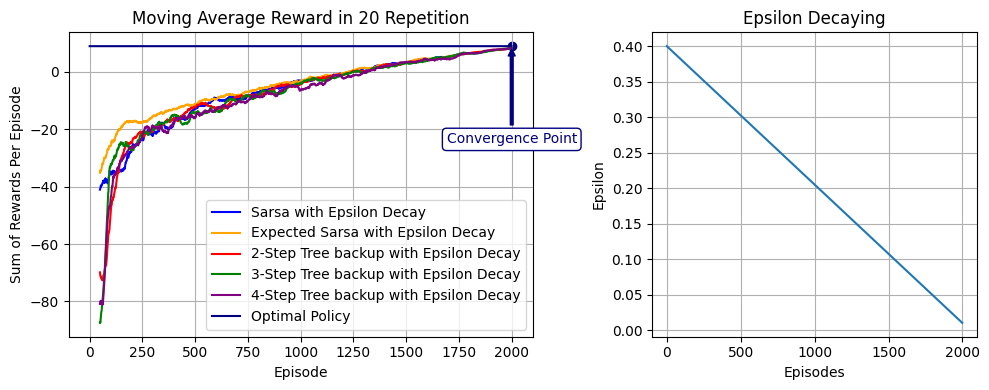

In [26]:
fig = plt.figure(tight_layout=True,figsize=(10,4))
gs = gridspec.GridSpec(1, 2,width_ratios=[5,3.5])

ax = fig.add_subplot(gs[0, 0])
ax.plot(Result_Sarsa,'b',label="Sarsa with Epsilon Decay")
# ax.plot([49,2000],[float(Result_Sarsa.iloc[49]),float(Result_Sarsa.iloc[1999])], 'b', linestyle="--")
ax.plot(Result_Expexted_Sarsa,'orange',label="Expected Sarsa with Epsilon Decay")
ax.plot(Result_2_step,'r',label="2-Step Tree backup with Epsilon Decay")
ax.plot(Result_3_step,'g',label="3-Step Tree backup with Epsilon Decay")
ax.plot(Result_4_step,'purple',label="4-Step Tree backup with Epsilon Decay")
if Res_Sarsa[EPISODES-1][REPS-1]==9.0:
    ax.scatter(2000,9,color='navy')
    ax.annotate("Convergence Point",color='navy', xy =(2000, 9),  xycoords='data',
                bbox=dict(boxstyle="round",fc="white", ec="navy"),
                xytext=(0, -70), textcoords='offset points', ha='center',
                arrowprops=dict(arrowstyle="simple",color="navy"))
ax.plot([9]*2000,'navy',label="Optimal Policy")

ax.set_ylabel("Sum of Rewards Per Episode")
ax.set_xlabel("Episode")
plt.title("Moving Average Reward in %d Repetition"%REPS)
plt.legend()
plt.grid()

ax = fig.add_subplot(gs[0, 1])
ax.plot(eps_decay)
ax.set_ylabel('Epsilon')
ax.set_xlabel('Episodes')
plt.title("Epsilon Decaying")
plt.grid()

### Regret Analysis

In [27]:
Regret_Q_2step=float(9*EPISODES-np.sum(Q_2step))
Regret_Q_3step=float(9*EPISODES-np.sum(Q_3step))
Regret_Q_4step=float(9*EPISODES-np.sum(Q_4step))
Regret_Q_E_sarsa=float(9*EPISODES-np.sum(Q_E_sarsa))
Regret_Q_sarsa=float(9*EPISODES-np.sum(Q_sarsa))
R_name=["Regret_Q_2step","Regret_Q_3step","Regret_Q_4step","Regret_Q_E_sarsa","Regret_Q_sarsa"]
R=[Regret_Q_2step,Regret_Q_3step,Regret_Q_4step,Regret_Q_E_sarsa,Regret_Q_sarsa]
X=R
for i in R:   
    for j in X:
        if i!=j and i<j:
            print(R_name[R.index(i)],"is better than",R_name[R.index(j)]," -> ","The Difference is: %.3f"%abs(i-j))
    print("~"*70)

Regret_Q_2step is better than Regret_Q_3step  ->  The Difference is: 965.097
Regret_Q_2step is better than Regret_Q_4step  ->  The Difference is: 1790.968
Regret_Q_2step is better than Regret_Q_E_sarsa  ->  The Difference is: 1995.510
Regret_Q_2step is better than Regret_Q_sarsa  ->  The Difference is: 5200.251
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Regret_Q_3step is better than Regret_Q_4step  ->  The Difference is: 825.871
Regret_Q_3step is better than Regret_Q_E_sarsa  ->  The Difference is: 1030.413
Regret_Q_3step is better than Regret_Q_sarsa  ->  The Difference is: 4235.153
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Regret_Q_4step is better than Regret_Q_E_sarsa  ->  The Difference is: 204.542
Regret_Q_4step is better than Regret_Q_sarsa  ->  The Difference is: 3409.282
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Regret_Q_E_sarsa is better than Regret_Q_sarsa  ->  The Difference is: 3204.740
~~

### Testing Q3 Results

In [28]:
test_agent(Q_2step)

Initial State
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Repeat:0 Episode:0 Step:0
   Action: left
   Reward: -1
   Passenger: R
   Destination: G
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
Repeat:0 Episode:0 Step:1
   Action: up
   Reward: -1
   Passenger: R
   Destination: G
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
Repeat:0 Episode:0 Step:2
   Action: pick-up
   Reward: -1
   Passenger: In Taxi
   Destination: G
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
Repeat:0 Episode:0 Step:3
   Action: down
   Reward: -1
   Passenger: In Taxi
   Destination: G
+---------+
|R: | : :G|
|_: | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
Repeat:0 Episode:0 Step:4
   Action: right
   Reward: -1
   Passenger: In Taxi
   Destination: G
+---------+
|R: | : :G|
| :_| : : |
| : : : : |
| | : |

## Q4

In [29]:
def on_policy_MC(env=env,lr=LEARNING_RATE,epsilon=EPSILON,epsilon_dacay=False,print_info=False):
    start=time.time()
    episode_reward=np.zeros(shape=(EPISODES,REPS))
    t_terminal=[]
    Q=np.random.rand(env.observation_space.n, env.action_space.n)
    policy = np.zeros_like(Q)
    policy[np.arange(len(Q)), Q.argmax(1)] = 1
    for r in range(REPS):
        Returns=np.array([[[]]*len(action_space.keys())]*n_states).tolist()
        if epsilon_dacay:
            epsilon=EPSILON
        for e in range(EPISODES):
            print("Repeat: %d Episode:%d"%(r,e))
            clear_output(wait=True)
            Episodes=[]
            Terminal=False
            env.seed(seed = STUDENT_NUM)
            current_state=env.reset()
            total_reward=0
            T=0
            while(Terminal == False):
                current_action=np.random.choice(list(action_space.keys()),p=policy[current_state])
                next_state,observed_reward,Terminal,_=env.step(current_action)
                Episodes.append((current_state,current_action,observed_reward))
                current_state=next_state
                total_reward+=observed_reward
            g=0
            T=len(Episodes)
            state_action = [(s, a) for (s, a, r) in Episodes]
            for t in range(T-1,-1,-1):
                g = DISCOUNT * g + Episodes[t][2]
                if (Episodes[t][0], Episodes[t][1]) not in state_action[:t]:
                    Returns[Episodes[t][0]][Episodes[t][1]].append(g)
                Q[Episodes[t][0]][Episodes[t][1]] = np.mean(Returns[Episodes[t][0]][Episodes[t][1]]) if len(
                    Returns[Episodes[t][0]][Episodes[t][1]])!= 0 else 0
                optimal_action = np.argmax(Q[Episodes[t][0]])
                for a in range(len(action_space)):
                    if a == optimal_action:
                        policy[Episodes[t][0]][a] = 1 - epsilon + (epsilon / len(action_space))
                    else:
                        policy[Episodes[t][0]][a] = epsilon / len(action_space)
                if epsilon_dacay:
                    epsilon = (EPSILON - MIN_EPSILON) * max(0, (EPISODES - e) / EPISODES) + MIN_EPSILON
            episode_reward[e][r]=total_reward
    print("Total Execution Time: %.2f Seconds"%(time.time()-start))
    return Q,episode_reward

### Training

In [30]:
Q_MC_Decay,RES_MC_decay=on_policy_MC(epsilon_dacay=True)

Total Execution Time: 221.59 Seconds


In [31]:
Q_MC,RES_MC=on_policy_MC(epsilon=0.1)

Total Execution Time: 629.78 Seconds


In [32]:
Result_MC_decay=pd.DataFrame(np.mean(RES_MC_decay,axis=1))
Result_MC=pd.DataFrame(np.mean(RES_MC,axis=1))
Result_MC=Result_MC.rolling(WINDOW_SIZE).mean()
Result_MC_decay=Result_MC_decay.rolling(WINDOW_SIZE).mean()

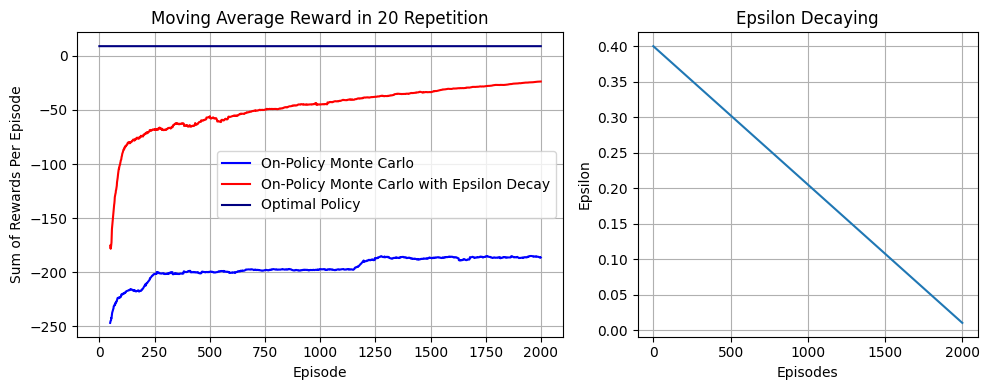

In [33]:
fig = plt.figure(tight_layout=True,figsize=(10,4))
gs = gridspec.GridSpec(1, 2,width_ratios=[5,3.5])

ax = fig.add_subplot(gs[0, 0])
ax.plot(Result_MC,'b',label="On-Policy Monte Carlo")
ax.plot(Result_MC_decay,'r',label="On-Policy Monte Carlo with Epsilon Decay")
ax.plot([9]*EPISODES,'navy',label="Optimal Policy")

ax.set_ylabel("Sum of Rewards Per Episode")
ax.set_xlabel("Episode")
plt.title("Moving Average Reward in %d Repetition"%REPS)
plt.legend()
plt.grid()

ax = fig.add_subplot(gs[0, 1])
ax.plot(eps_decay)
ax.set_ylabel('Epsilon')
ax.set_xlabel('Episodes')
plt.title("Epsilon Decaying")
plt.grid()

### Regret Analysis

In [34]:
Regret_MC_Decay=float(9*EPISODES-np.sum(Result_MC_decay))
Regret_MC=float(9*EPISODES-np.sum(Result_MC))
if Regret_MC<Regret_MC_Decay:
    print("On-Policy MC with %.1f Epsilon is better than decaying Epsilon."%EPSILON)
else:
    print("On-Policy MC with decaying Epsilon is better than %.1f Epsilon."%EPSILON)
print("The Difference is: %.3f"%abs(Regret_MC_Decay-Regret_MC))

On-Policy MC with decaying Epsilon is better than 0.4 Epsilon.
The Difference is: 289314.659


### Testing Q4 Results

In [35]:
test_agent(Q_MC_Decay)

Initial State
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Repeat:0 Episode:0 Step:0
   Action: left
   Reward: -1
   Passenger: R
   Destination: G
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
Repeat:0 Episode:0 Step:1
   Action: up
   Reward: -1
   Passenger: R
   Destination: G
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
Repeat:0 Episode:0 Step:2
   Action: pick-up
   Reward: -1
   Passenger: In Taxi
   Destination: G
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
Repeat:0 Episode:0 Step:3
   Action: right
   Reward: -1
   Passenger: In Taxi
   Destination: G
+---------+
|R:_| : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
Repeat:0 Episode:0 Step:4
   Action: down
   Reward: -1
   Passenger: In Taxi
   Destination: G
+---------+
|R: | : :G|
| :_| : : |
| : : : : |
| | : | 